In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

In [3]:
#这次改一下PC

In [4]:
# 读取文本文件
file_path = 'J:/空间代谢组\乳腺癌课题/09-2_coordinates_intensities.txt'  # 替换为你的文件路径
data_df = pd.read_csv(file_path, sep='\t')  # 假设数据是以制表符分隔的

In [5]:
# 获取第一行和第二行的数据（不包括索引）
first_row = data_df.iloc[:, 2]  # 假设第一行的索引是0，并且跳过第一列
second_row = data_df.iloc[:, 3]  # 同上，假设第二行的索引是1
X_spatial = np.stack((first_row.to_numpy(), second_row.to_numpy()), axis=-1)
index = first_row.astype(str) + 'x' + second_row.astype(str)
data_df.index = index

In [6]:
data_df = data_df.drop(data_df.columns[0:4], axis=1)
data_df = data_df.applymap(lambda x: float(x / 10))
data_df = data_df.astype(int)

In [7]:
np.max(data_df)

486

In [8]:
adata = ad.AnnData(X=data_df)
# 将DataFrame的行索引添加为AnnData的obs（观察对象）的索引
adata.obs = pd.DataFrame(index=data_df.index)
# 将DataFrame的列索引添加为AnnData的var（变量）的索引
adata.var = pd.DataFrame(index=data_df.columns)
adata.obsm['X_spatial'] = X_spatial

In [9]:
adata

AnnData object with n_obs × n_vars = 40919 × 947
    obsm: 'X_spatial'

In [10]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()

In [11]:
# sc.pp.filter_cells(adata, min_counts=20)
# #sc.pp.filter_cells(adata, max_counts=35000)
# print(f"#cells after MT filter: {adata.n_obs}")
# sc.pp.filter_genes(adata, min_cells=10)

In [12]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)


In [13]:
sc.pp.pca(adata,n_comps=100)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [14]:
sc.tl.leiden(
    adata,
    resolution=0.4,
    random_state=0,
    
    n_iterations=2,
    directed=False,
)

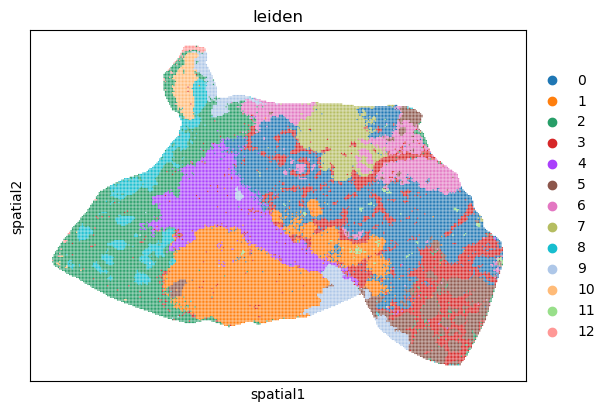

In [15]:
sc.pl.spatial(adata, color="leiden", spot_size=1)

In [40]:
bayes_df = pd.read_csv('9-2/9_2_BayesSpace.csv',index_col=0)
adata.obs['cluster'] = bayes_df
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

In [42]:
adata.obs

,leiden,cluster
95x1,12,11
96x1,12,11
97x1,12,11
98x1,12,11
99x1,12,11
...,...,...
286x227,5,12
287x227,5,12
288x227,2,12
289x227,8,12


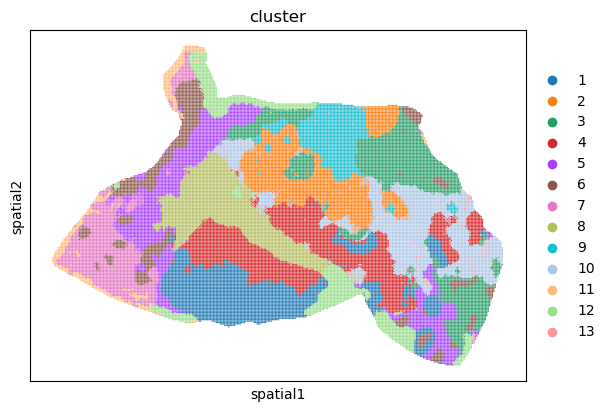

In [43]:
sc.pl.spatial(adata, color="cluster", spot_size=1)

In [44]:
adata.write_h5ad("meta0719_clz92_01.h5ad")

In [39]:
rna_spatial = sc.read_visium('LBC_DCIS_IC/outs')

D:\BoYao\Anaconda3\envs\bc\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\BoYao\Anaconda3\envs\bc\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [40]:
adata = rna_spatial
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
#adata.X = (adata.X / 5).astype(int)
adata.layers["counts"] = adata.X.copy()

In [41]:
rna_spatial

AnnData object with n_obs × n_vars = 2172 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'

In [42]:
np.max(adata.layers["counts"])

263

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

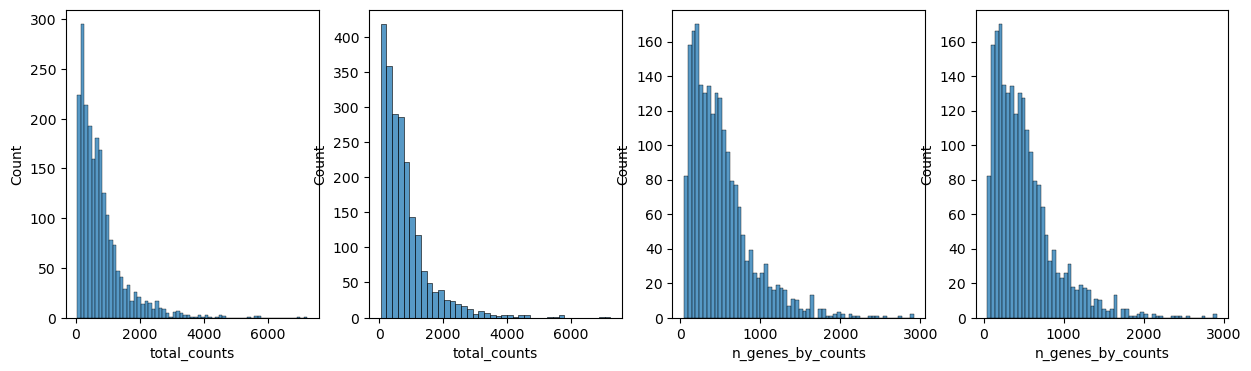

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [44]:
# sc.pp.filter_cells(adata, min_counts=20)
# sc.pp.filter_cells(adata, max_counts=35000)
# adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
# print(f"#cells after MT filter: {adata.n_obs}")
# sc.pp.filter_genes(adata, min_cells=5)

In [45]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

In [46]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
#sc.pp.scale(adata)

In [47]:
sc.pp.pca(adata,n_comps=100)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

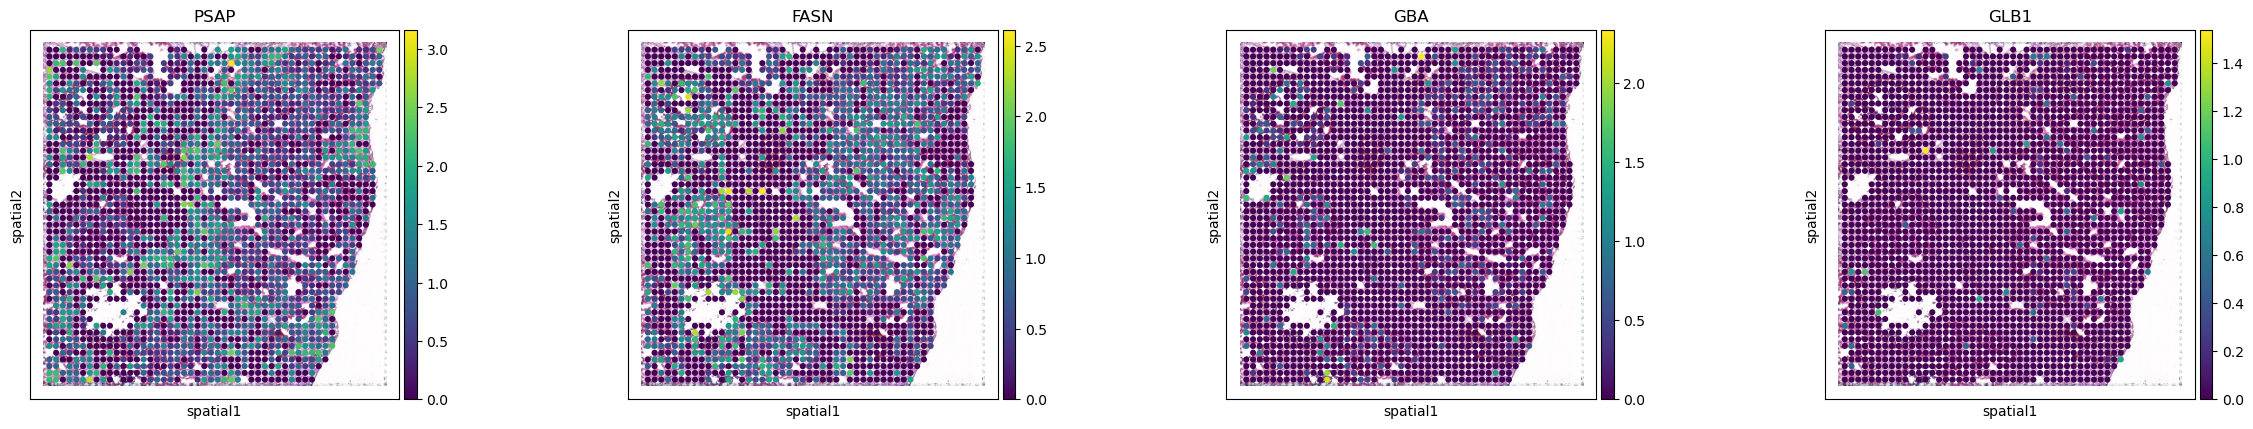

In [52]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["PSAP",'FASN','GBA','GLB1'],
    size=0.9,
)

In [34]:
sc.tl.leiden(
    adata,
    resolution=0.6,
    random_state=0,
    
    n_iterations=2,
    directed=True,
)

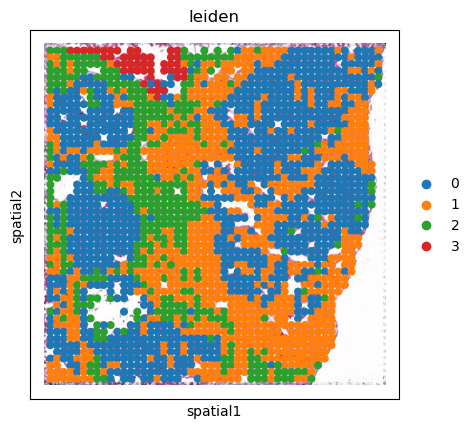

In [35]:
sc.pl.spatial(adata, color="leiden", size=1.2,img=None)

In [23]:
bayes_df = pd.read_csv('LBC_DCIS_IC/bayes.csv',index_col=0)
adata.obs['cluster'] = bayes_df
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

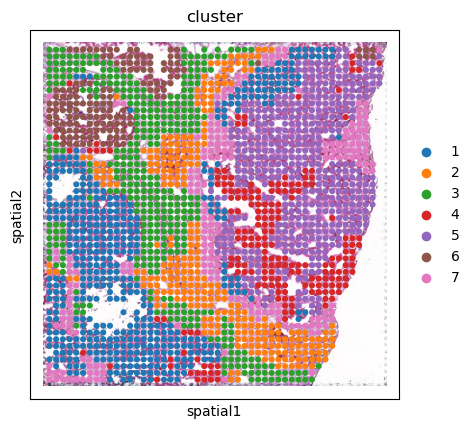

In [37]:
sc.pl.spatial(adata, img_key="hires", color="cluster", size=0.9)

In [38]:
adata.write_h5ad("rna0703_lbc_st.h5ad")

In [16]:
kegg_meta = pd.read_csv('D:/BoYao/python_file/scglue/hsa_kegg通路对应代谢物.csv')

In [17]:
mt_meta = pd.read_excel('D:/BoYao/python_file/scglue/ALL_sample_data_2.xlsx')

In [18]:
# 进行部分列的合并，选择 data1 的 'KEGG.ID' 列和 data2 的 'KEGG' 列
merged_data_mt = pd.merge(kegg_meta, mt_meta, left_on='KEGG.ID', right_on='KEGG', how='inner')

# 选择合并后的数据框中需要的列
merged_data_mt = merged_data_mt[['KEGG.ID', 'pathway_id', 'Precursor (Da)']]

merged_data_mt

,KEGG.ID,pathway_id,Precursor (Da)
0,C00191,hsa00040,176.9941
1,C00191,hsa00053,176.9941
2,C00191,hsa00520,176.9941
3,C00191,hsa00562,176.9941
4,C01096,hsa00051,300.9468
...,...,...,...
135,C00318,hsa05415,162.1131
136,C01576,hsa04976,589.2764
137,C05371,hsa04976,995.5395
138,C06810,hsa04976,226.1060


In [19]:
kegg_rna = pd.read_csv('D:/BoYao/python_file/scglue/hsa_kegg通路对应基因.csv')
kegg_rna.head()

,Unnamed: 0,gene_name,KO_ID,gene_des,EC,ENTREZID,pathway_id,pathway_name,level1_pathway_name,level2_pathway_name
0,1,HK3,K00844,hexokinase 3,2.7.1.1,3101,hsa00010,Glycolysis / Gluconeogenesis,Metabolism,Carbohydrate metabolism
1,2,HK1,K00844,hexokinase 1,2.7.1.1,3098,hsa00010,Glycolysis / Gluconeogenesis,Metabolism,Carbohydrate metabolism
2,3,HK2,K00844,hexokinase 2,2.7.1.1,3099,hsa00010,Glycolysis / Gluconeogenesis,Metabolism,Carbohydrate metabolism
3,4,HKDC1,K00844,hexokinase domain containing 1,2.7.1.1,80201,hsa00010,Glycolysis / Gluconeogenesis,Metabolism,Carbohydrate metabolism
4,5,GCK,K12407,glucokinase,2.7.1.2,2645,hsa00010,Glycolysis / Gluconeogenesis,Metabolism,Carbohydrate metabolism


In [20]:
rna = ad.read_h5ad("rna0703_lbc_st.h5ad")
meta = ad.read_h5ad('meta0705_clz92_01.h5ad')
rna.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0,0.000000,False,1.000000e-12,NaN,NaN,0.000000,1.000000
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,32,0.014733,0.014625,98.526703,32,3.496508,False,2.500026e-02,0.526943,-0.322438,0.006924,0.066393


In [21]:
st_rna = pd.DataFrame(rna.var)

In [22]:
# 进行部分列的合并，选择 data1 的 'KEGG.ID' 列和 data2 的 'KEGG' 列
merged_data_st = pd.merge(kegg_rna, st_rna, left_on='gene_name',right_index=True, how='inner')

# 选择合并后的数据框中需要的列
merged_data_st = merged_data_st[['gene_name', 'pathway_id']]

merged_data_st

,gene_name,pathway_id
0,HK3,hsa00010
174,HK3,hsa00051
205,HK3,hsa00052
286,HK3,hsa00500
304,HK3,hsa00520
...,...,...
34317,PPARGC1B,hsa04931
34327,OGA,hsa04931
34467,ASH2L,hsa04934
34468,RBBP5,hsa04934


In [23]:
import networkx as nx

# 创建一个无向图
G = nx.Graph()

# 添加节点
# 从 rna.var 中选择 highly_variable 的行名
rna_nodes_to_add = rna.var.index.tolist()

# 从 meta.var 中选择 highly_variable  的行名
meta_nodes_to_add = meta.var.index.tolist()

# 将两个列表合并为一个 nodes_to_add 列表
nodes_to_add = rna_nodes_to_add + meta_nodes_to_add


G.add_nodes_from(nodes_to_add)

In [24]:
common_pathway_ids = set(merged_data_mt['pathway_id']).intersection(set(merged_data_st['pathway_id']))
common_pathway_ids

{'hsa00040',
 'hsa00051',
 'hsa00052',
 'hsa00053',
 'hsa00071',
 'hsa00130',
 'hsa00140',
 'hsa00220',
 'hsa00230',
 'hsa00232',
 'hsa00240',
 'hsa00310',
 'hsa00330',
 'hsa00340',
 'hsa00350',
 'hsa00380',
 'hsa00400',
 'hsa00410',
 'hsa00470',
 'hsa00480',
 'hsa00520',
 'hsa00562',
 'hsa00564',
 'hsa00565',
 'hsa00590',
 'hsa00591',
 'hsa00592',
 'hsa00600',
 'hsa00740',
 'hsa00750',
 'hsa00770',
 'hsa00790',
 'hsa00860',
 'hsa00900',
 'hsa00970',
 'hsa00980',
 'hsa00982',
 'hsa00983',
 'hsa02010',
 'hsa04024',
 'hsa04071',
 'hsa04080',
 'hsa04148',
 'hsa04150',
 'hsa04152',
 'hsa04216',
 'hsa04217',
 'hsa04540',
 'hsa04610',
 'hsa04614',
 'hsa04664',
 'hsa04713',
 'hsa04714',
 'hsa04721',
 'hsa04723',
 'hsa04726',
 'hsa04728',
 'hsa04917',
 'hsa04924',
 'hsa04974',
 'hsa04976',
 'hsa04977',
 'hsa05012',
 'hsa05014',
 'hsa05022',
 'hsa05030',
 'hsa05031',
 'hsa05032',
 'hsa05034',
 'hsa05142',
 'hsa05146',
 'hsa05171',
 'hsa05207',
 'hsa05230',
 'hsa05231',
 'hsa05310',
 'hsa05415'}

In [25]:
# 根据共有的 'pathway_id' 建立图中的边
for pathway_id in common_pathway_ids:
    # 从 data1 中找到对应 'pathway_id' 的 'gene_name'
    gene_name = merged_data_st.loc[merged_data_st['pathway_id'] == pathway_id, 'gene_name'].values[0]

    # 从 data2 中找到对应 'pathway_id' 的 'Precursor (Da)'
    precursor_da = merged_data_mt.loc[merged_data_mt['pathway_id'] == pathway_id, 'Precursor (Da)'].values[0]

    # 添加边到图中
    G.add_edge(gene_name, precursor_da, weight=0.5, sign=1)

# 添加每个节点的自环，weight = 1，sign = 1
for node in G.nodes:
    G.add_edge(node, node, weight=1, sign=1)

In [26]:
G.number_of_nodes(),G.number_of_edges()

(37581, 37651)

In [27]:
nx.write_graphml(G, "Guidance_0706_lbc_clz92_01.graphml.gz")